# Shor's Algorithm to factor N = 15
* In this notebook we demo Shor's Algorithm
* Show how it works in an Ideal scenario
* Explore implementations on realistice hardware with noise

In [ ]:
import shutil
import os

# Remove the existing directory if it exists
# useful during development when testing updates
if os.path.exists('shor_eecs298'):
    shutil.rmtree('shor_eecs298')

# Clone repo
!git clone https://github.com/radubach/shor_eecs298.git --depth 1
%cd shor_eecs298
import sys
sys.path.append('./src')

Cloning into 'shor_eecs298'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.79 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/shor_eecs298


In [ ]:
!pip install -r requirements.txt

In [ ]:
from utils import c_7mod15, qft_dagger, qpe_mod15, make_custom_noise_model
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit_aer import AerSimulator
import pandas as pd
from fractions import Fraction
from math import gcd, floor, log
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import CountOps
import matplotlib.pyplot as plt
import numpy as np

N = 15 # number to factor
a = 7 # integer used in a^x mod N
## paramter a must be coprime to N (gcd(a,N) = 1)
## a should be chosen randomly, then verify it is coprime to N
## some a values will not work, and the algorithm needs to be retried with different a
## we know a = 7 works for N = 1, so we use it in this demo

#Design the High Level Circuit

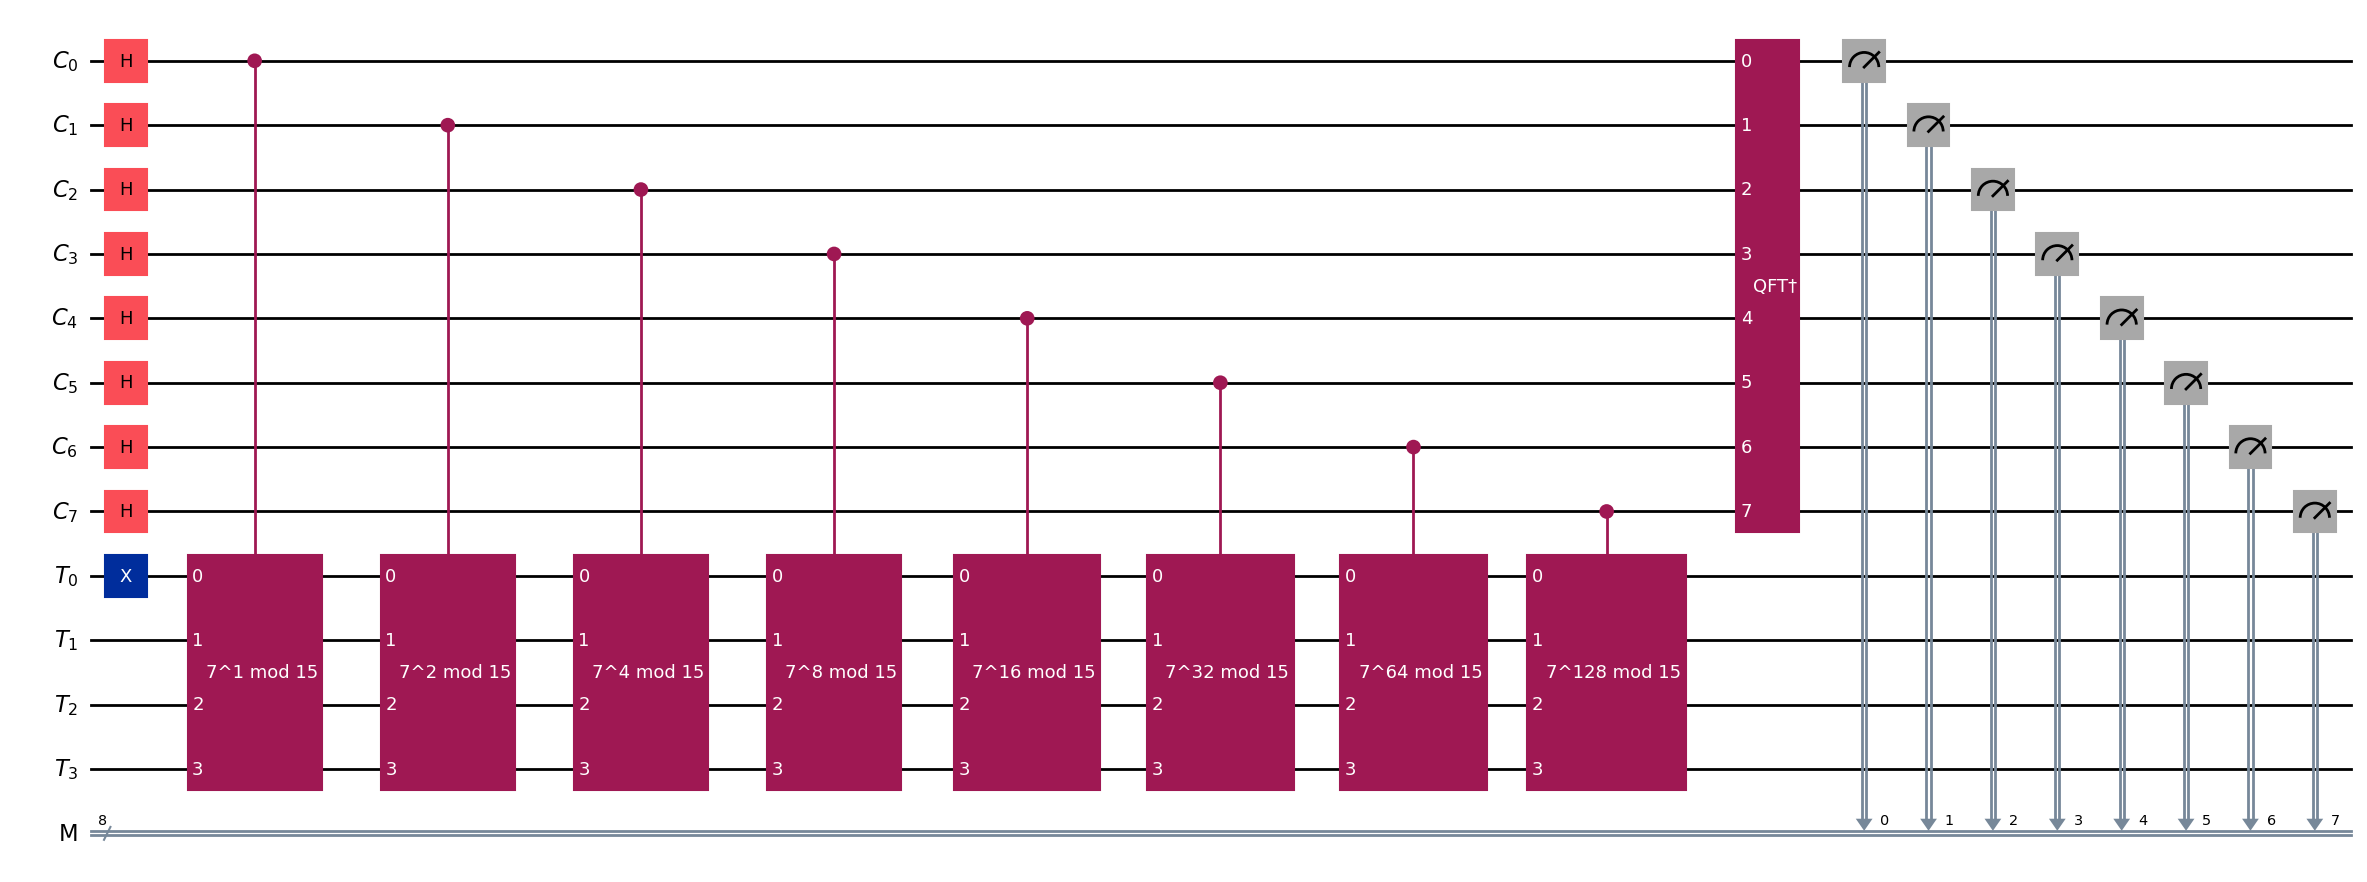

In [ ]:
target_n_qubits = floor(log(N - 1, 2)) + 1 # mod N function can have N possible outcomes from 0 to N-1
control_n_qubits = target_n_qubits * 2 # allows for at least N^2 values

control = QuantumRegister(control_n_qubits, name='C')    # control register
target = QuantumRegister(target_n_qubits, name='T')           # target register
measurement = ClassicalRegister(control_n_qubits, name='M')       # classical bits for measurement

qc = QuantumCircuit(control, target, measurement)

# Apply Hadamards to control register - put control into state of equal superposition
qc.h(control)

# Initialize target register to 1
qc.x(target[0])  # a^0 mod N = 1

# Controlled-U operations - entangle control with target, target values are results of mod function
for q in range(control_n_qubits):
    qc.append(c_7mod15(2 ** q), [control[q]] + target[:]) # Note that c_7mod15() expects the target to have 4 qubits

# Inverse inverse-QFT to reveal periodicity and measure
qc.append(qft_dagger(control_n_qubits), control)
qc.measure(control, measurement)

qc.draw(fold = -1)
circuit_drawer(qc,output = 'mpl', filename = 'circuit.png',fold = -1)

# Simulate Results Under Ideal Conditions
* Simulator makes no errors
* Simulator allows for 3 qubit gates

In [ ]:
# ideal, noiseless simulator
aer_sim = AerSimulator()

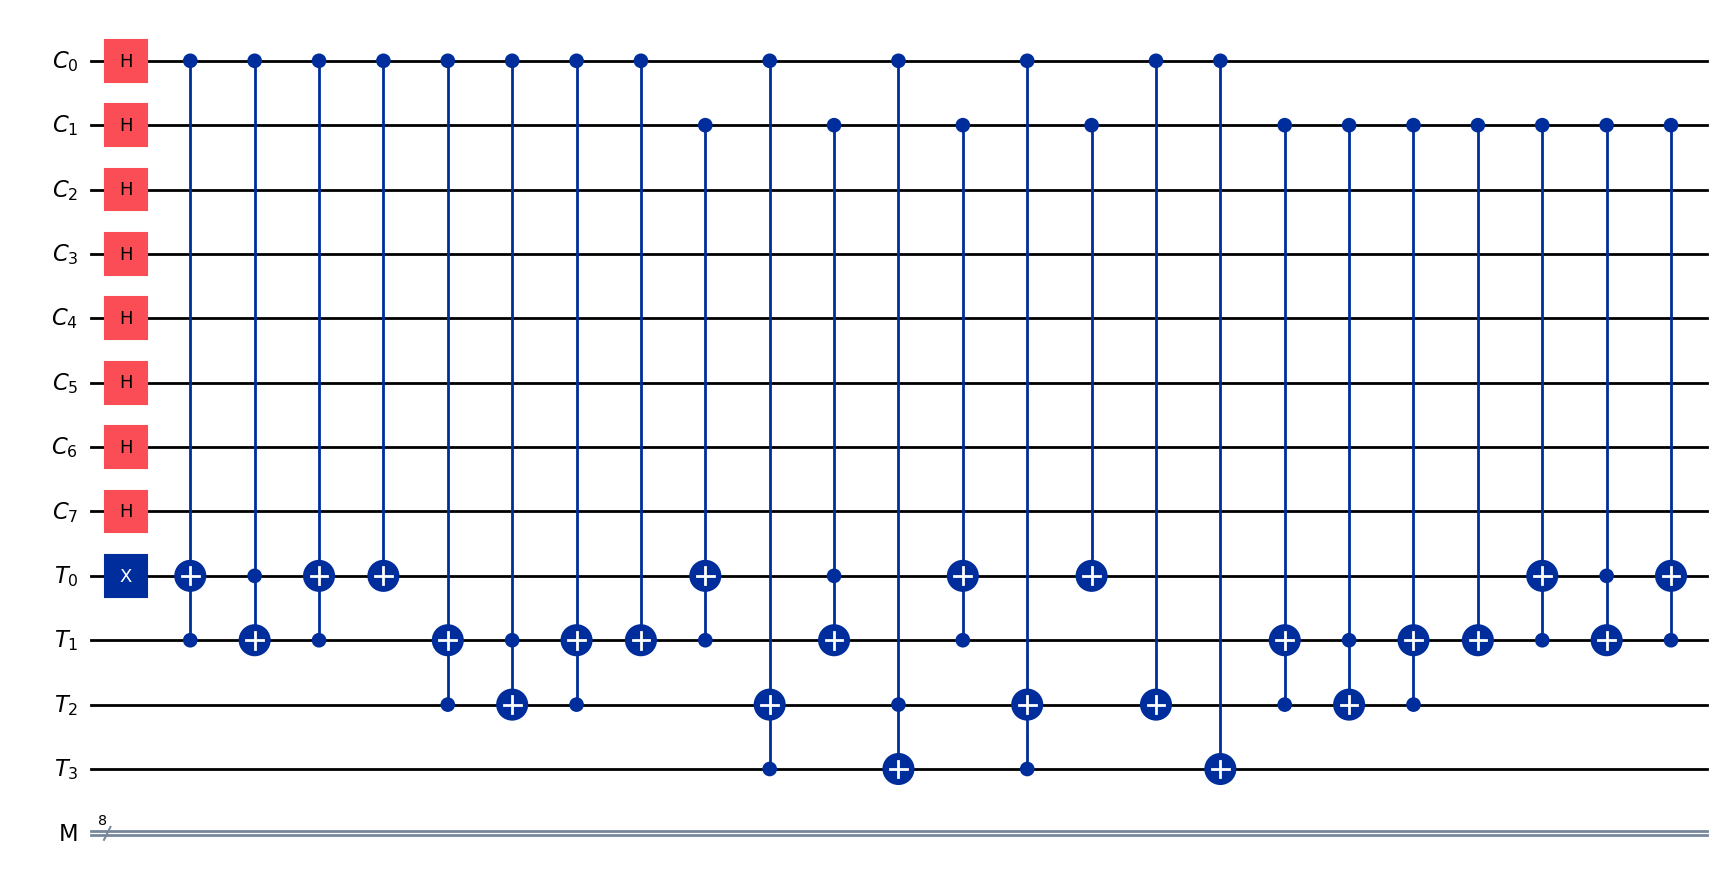

In [ ]:
# transpiled circuit, noiseless simulator
t_qc = transpile(qc, aer_sim, optimization_level=0)

# draw just the beginning of the circuit to save time and space
sub_qc = t_qc.copy()
sub_qc.data = sub_qc.data[:33]
sub_qc.draw('mpl', style='iqp')


In [ ]:
circuit = t_qc

# Print a summary
print("🔧 Circuit diagnostics:")
print("- Total qubits:     ", circuit.num_qubits)
print("- Total gates:      ", circuit.size())
print("- Circuit depth:    ", circuit.depth())
print("- Classical bits:   ", circuit.num_clbits)

# Breakdown of gate types
print("\n🧱 Gate breakdown:")
gate_counts = circuit.count_ops()
for gate, count in gate_counts.items():
    print(f"- {gate:8}: {count}")

🔧 Circuit diagnostics:
- Total qubits:      12
- Total gates:       3372
- Circuit depth:     3298
- Classical bits:    8

🧱 Gate breakdown:
- ccx     : 2295
- cx      : 1020
- cp      : 28
- h       : 16
- measure : 8
- swap    : 4
- x       : 1


In [ ]:
q_obj = aer_sim.run(t_qc)
results = q_obj.result()
counts = results.get_counts()

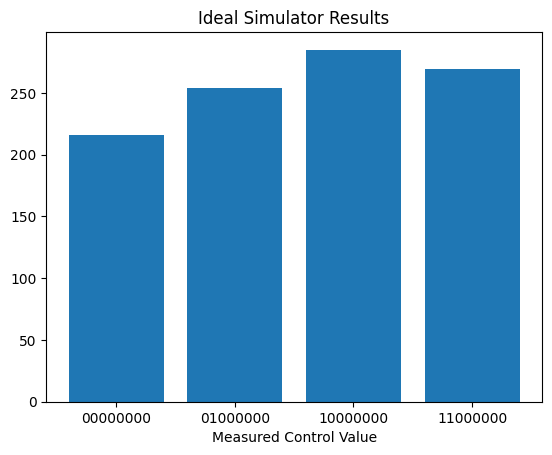

In [ ]:
states = list(counts.keys())
values = list(counts.values())
# Sort by states
sorted_data = sorted(zip(states, values))
states, values = zip(*sorted_data)
plt.bar(states, values)
plt.title('Ideal Simulator Results')
plt.xlabel('Measured Control Value')
plt.show()

#Simulate Results Under Realistic Conditions
* Simulator hs a small error rate
* Simulator does not allow 3 qubit gates

In [ ]:
# Create noise model with custom function from repo
noise_model = make_custom_noise_model(one_qubit_error=0.0001, two_qubit_error=0.005)

# Set up simulator with noise
sim_with_noise = AerSimulator(noise_model=noise_model)

Noise Model Configuration:
  1-qubit gates: 0.010% error rate
  2-qubit gates: 0.500% error rate


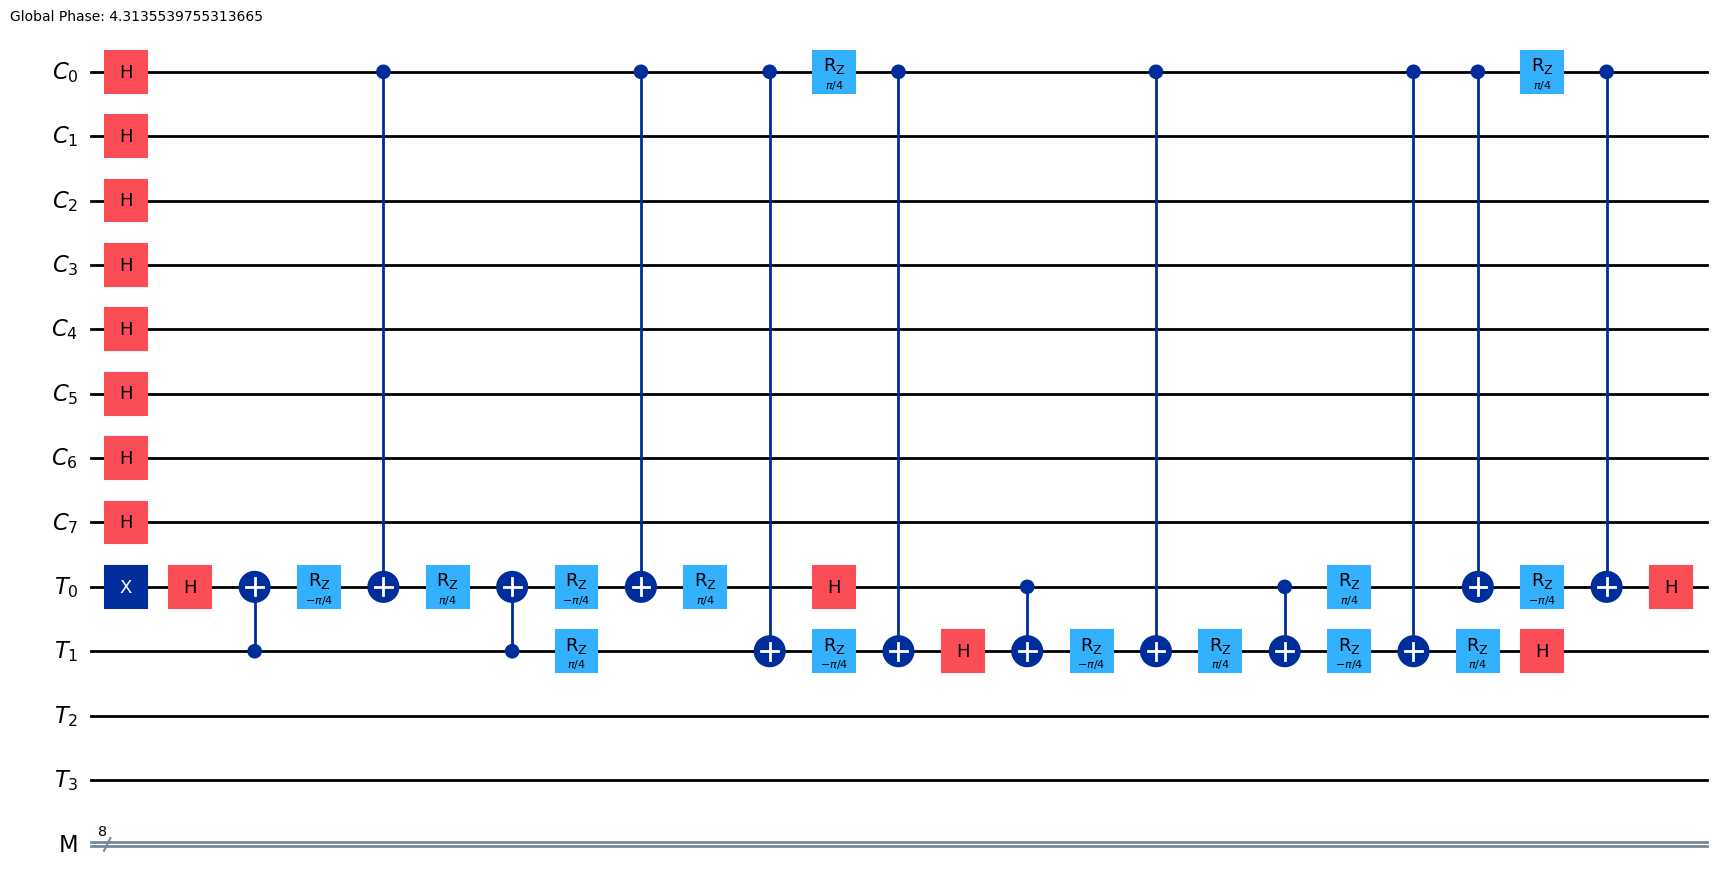

In [ ]:
# Transpile for this backend's coupling map
t_qc_noisy = transpile(qc, sim_with_noise, optimization_level=0)

# draw just the beginning of the circuit to save time and space
sub_qc = t_qc_noisy.copy()
sub_qc.data = sub_qc.data[:40]
sub_qc.draw('mpl', style='iqp')


In [ ]:
circuit = t_qc_noisy

# Print a summary
print("🔧 Circuit diagnostics:")
print("- Total qubits:     ", circuit.num_qubits)
print("- Total gates:      ", circuit.size())
print("- Circuit depth:    ", circuit.depth())
print("- Classical bits:   ", circuit.num_clbits)

# Breakdown of gate types
print("\n🧱 Gate breakdown:")
gate_counts = circuit.count_ops()
for gate, count in gate_counts.items():
    print(f"- {gate:8}: {count}")

🔧 Circuit diagnostics:
- Total qubits:      12
- Total gates:       35622
- Circuit depth:     25309
- Classical bits:    8

🧱 Gate breakdown:
- rz      : 16149
- cx      : 14858
- h       : 4606
- measure : 8
- x       : 1


In [ ]:
# !!!! WARNING !!!!
# Takes 10-15 minutes to run

# Run simulation
result = sim_with_noise.run(t_qc_noisy).result()
counts_noisy = result.get_counts()

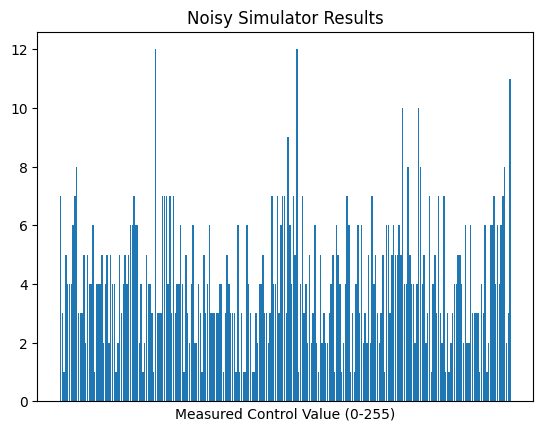

In [ ]:
states = list(counts_noisy.keys())
values = list(counts_noisy.values())
# Sort by states
sorted_data = sorted(zip(states, values))
states, values = zip(*sorted_data)
plt.bar(states, values)
plt.title('Noisy Simulator Results')
plt.xlabel('Measured Control Value (0-255)')
plt.xticks([])
plt.show()

#Optimized Circuit to Reduce Noise
* Target Register needs only 2 qubits, because there are only 4 possible values (unique to N = 15, a = 7)

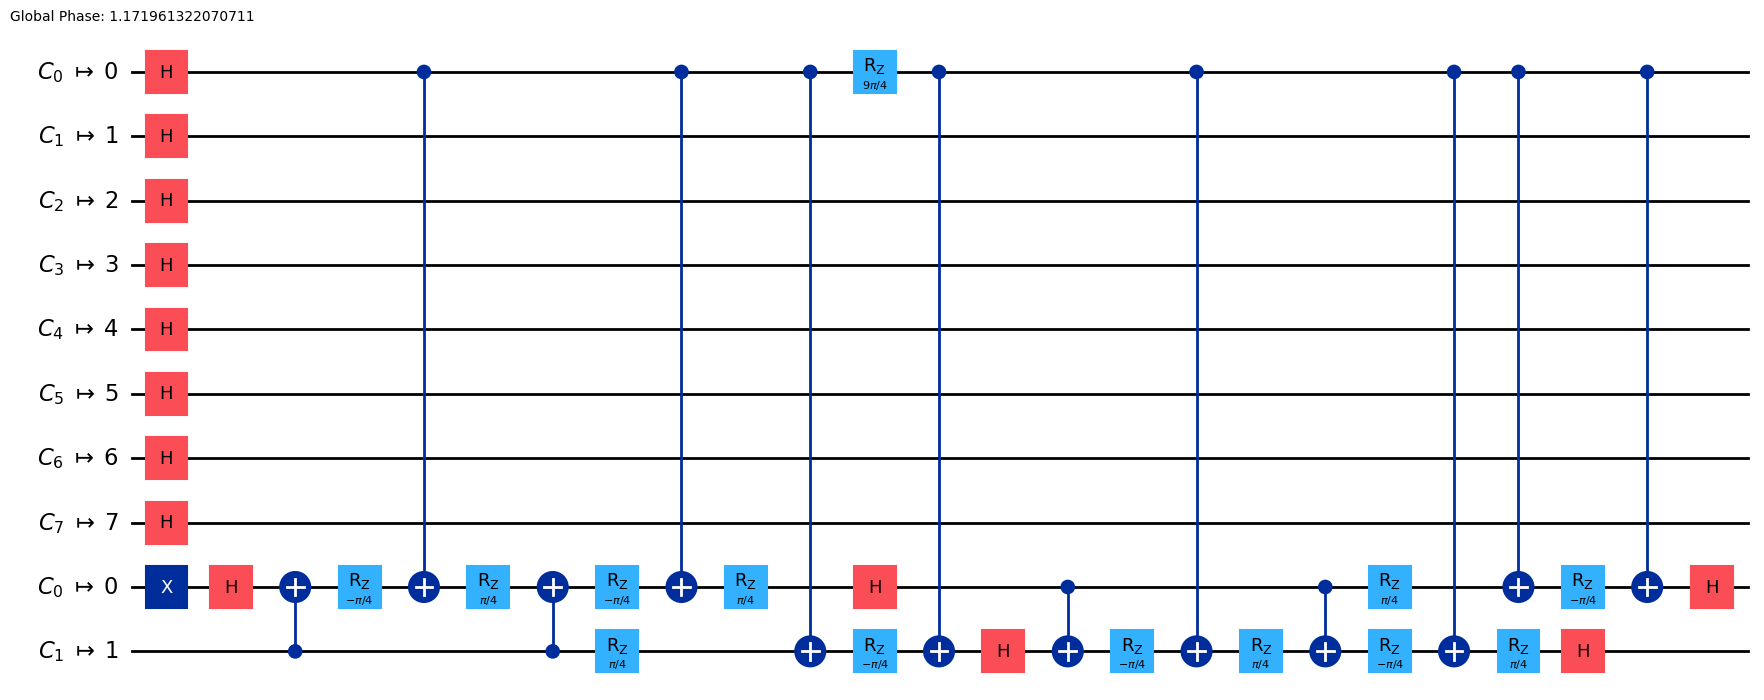

In [ ]:
t_qc_noisy_opt3 = transpile(qc, sim_with_noise, optimization_level=3)

# draw just the beginning of the circuit to save time and space
sub_qc = t_qc_noisy_opt3.copy()
sub_qc.data = sub_qc.data[:39]
sub_qc.draw('mpl', style='iqp')


In [ ]:
circuit = t_qc_noisy_opt3

# Print a summary
print("🔧 Circuit diagnostics:")
print("- Total qubits:     ", circuit.num_qubits)
print("- Total gates:      ", circuit.size())
print("- Circuit depth:    ", circuit.depth())
print("- Classical bits:   ", circuit.num_clbits)

# Breakdown of gate types
print("\n🧱 Gate breakdown:")
gate_counts = circuit.count_ops()
for gate, count in gate_counts.items():
    print(f"- {gate:8}: {count}")

🔧 Circuit diagnostics:
- Total qubits:      12
- Total gates:       32279
- Circuit depth:     24324
- Classical bits:    8

🧱 Gate breakdown:
- cx      : 14336
- rz      : 13328
- h       : 4606
- measure : 8
- x       : 1


In [ ]:
# !!!! WARNING !!!!
# Takes 10-15 minutes to run

# Run simulation
result = sim_with_noise.run(t_qc_noisy_opt3).result()
counts_noisy_opt3 = result.get_counts()

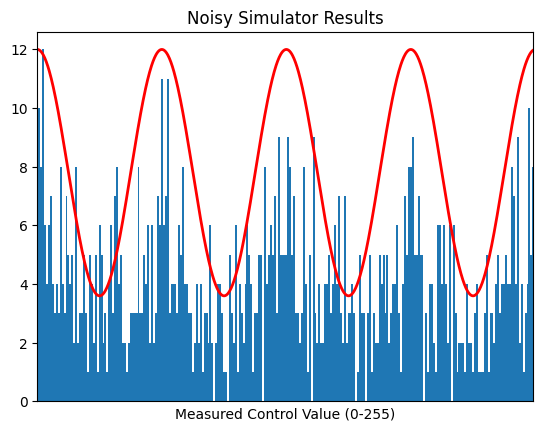

In [ ]:
states = list(counts_noisy_opt3.keys())
values = list(counts_noisy_opt3.values())

# Convert binary strings to integers
x_positions = [int(state, 2) for state in states]  # Convert from binary!

# Sort by the integer values
sorted_data = sorted(zip(x_positions, values))
x_positions, values = zip(*sorted_data)

# Create the bar plot
plt.bar(x_positions, values, label='Measurement Data', width=1)

# Create wave function with peaks at 0, 64, 128, 192
x_smooth = np.linspace(0, 255, 1000)
wave = np.max(values) * (0.3 + 0.7 * np.cos(np.pi * x_smooth / 64)**2)

plt.plot(x_smooth, wave, 'r-', linewidth=2, label='Expected Wave Function')
plt.title('Noisy Simulator Results')
plt.xlabel('Measured Control Value (0-255)')
plt.xlim(0, 255)
plt.xticks([])
# plt.legend()
plt.show()

#Reduce Control Register Size
* 4 qubits in Control register instead of 8
* Results in a much smaller circuit
* Fewer gates = Less Error

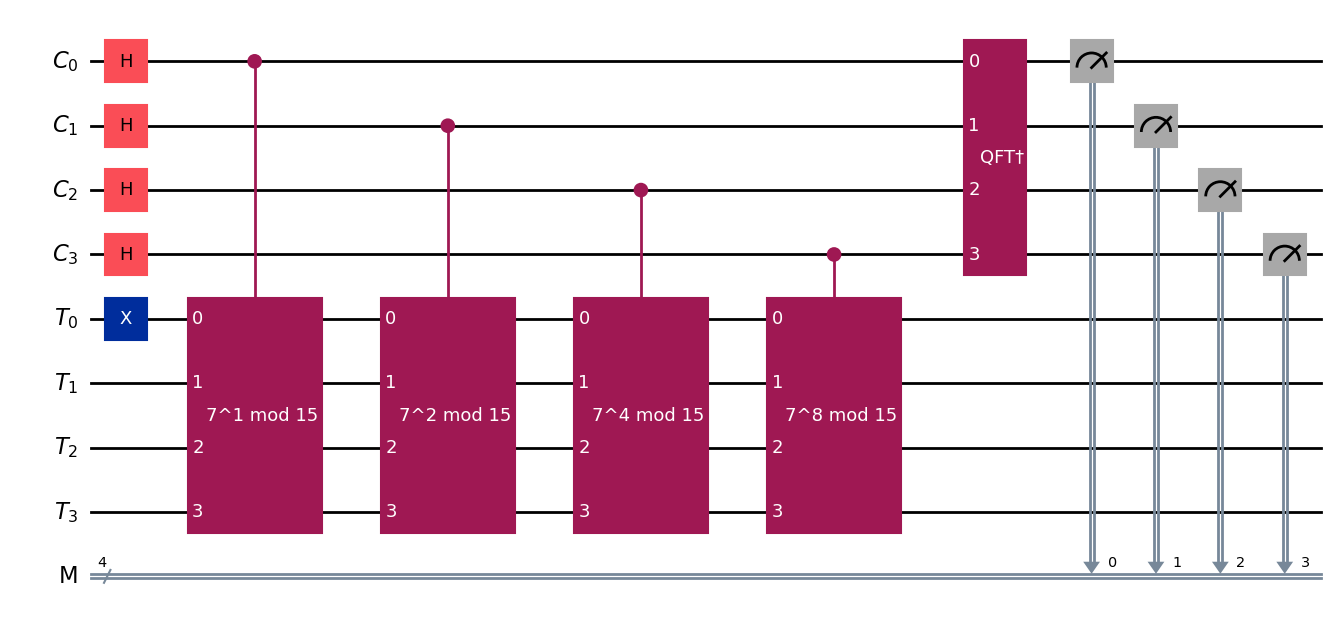

In [ ]:
n_small_c = 4

# Create all new registers to avoid conflicts
small_control = QuantumRegister(n_small_c, name='C')
small_target = QuantumRegister(4, name='T')  # still 4 qubits
small_measure = ClassicalRegister(n_small_c, name='M')

# Create new circuit with these registers
small_qc = QuantumCircuit(small_control, small_target, small_measure)

# Hadamards on control
small_qc.h(small_control)

# Initialize target to |1⟩
small_qc.x(small_target[0])

# Controlled modular multiplication
for q in range(n_small_c):
    small_qc.append(c_7mod15(2 ** q), [small_control[q]] + list(small_target))

# Inverse QFT and measure
small_qc.append(qft_dagger(n_small_c), small_control)
small_qc.measure(small_control, small_measure)

# Draw circuit
small_qc.draw(fold=-1)
circuit_drawer(small_qc, output='mpl', filename='small_circuit.png', fold=-1)


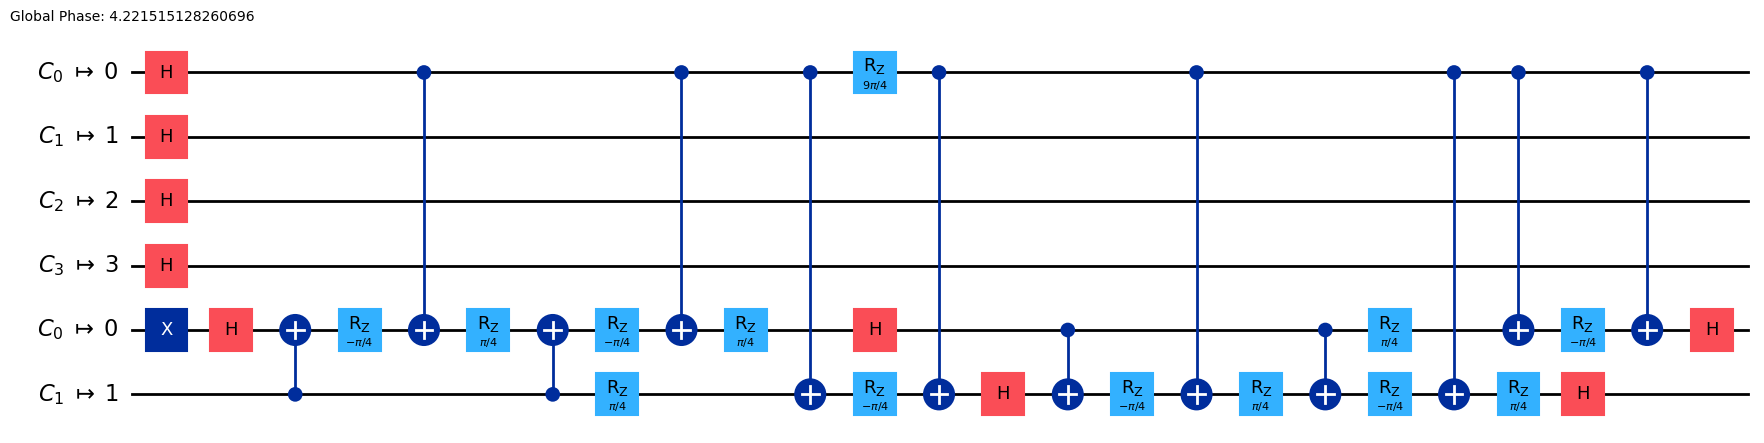

In [ ]:
t_small_qc_noisy_opt3 = transpile(small_qc, sim_with_noise, optimization_level=3)

# draw just the beginning of the circuit to save time and space
sub_qc = t_small_qc_noisy_opt3.copy()
sub_qc.data = sub_qc.data[:35]
sub_qc.draw('mpl', style='iqp')

In [ ]:
circuit = t_small_qc_noisy_opt3

# Print a summary
print("🔧 Circuit diagnostics:")
print("- Total qubits:     ", circuit.num_qubits)
print("- Total gates:      ", circuit.size())
print("- Circuit depth:    ", circuit.depth())
print("- Classical bits:   ", circuit.num_clbits)

# Breakdown of gate types
print("\n🧱 Gate breakdown:")
gate_counts = circuit.count_ops()
for gate, count in gate_counts.items():
    print(f"- {gate:8}: {count}")

🔧 Circuit diagnostics:
- Total qubits:      8
- Total gates:       1935
- Circuit depth:     1376
- Classical bits:    4

🧱 Gate breakdown:
- cx      : 852
- rz      : 800
- h       : 278
- measure : 4
- x       : 1


In [ ]:
# Run simulation
result = sim_with_noise.run(t_small_qc_noisy_opt3).result()
counts_noisy_small3 = result.get_counts()

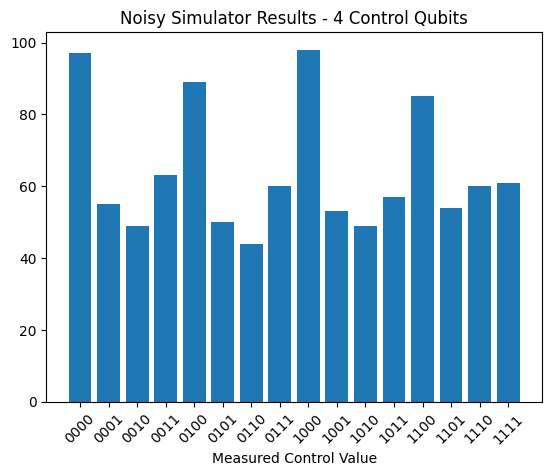

In [ ]:
states = list(counts_noisy_small3.keys())
values = list(counts_noisy_small3.values())
# Sort by states
sorted_data = sorted(zip(states, values))
states, values = zip(*sorted_data)
plt.bar(states, values)
plt.title('Noisy Simulator Results - 4 Control Qubits')
plt.xlabel('Measured Control Value')
plt.xticks(rotation=45)
plt.show()

#Post Processeing
* How the measurement can be converted to a phase estimate, and estimate for period r
* How to find factors of N from r
* Full implementation of Shor's algorithm to factor N

In [ ]:
rows, measured_phases = [], []

for output in counts:
  decimal = int(output, 2)
  phase = decimal/(2**control_n_qubits)
  measured_phases.append(phase)


  rows.append([f"{output}(bin) = {decimal:>3}(dec)",
               f"{decimal}/{2**control_n_qubits} = {phase:.2f}"])

headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns = headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [ ]:
rows = []
for phase in measured_phases:
  frac = Fraction(phase).limit_denominator(15) # denominator cant be greater than the number itself
  rows.append([phase, f"{frac.numerator}/{frac.denominator}",frac.denominator])

headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns = headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.75      3/4            4


In [ ]:
phase = qpe_mod15(a)
Fraction(phase).limit_denominator(15)
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print("r = %i" %r)
guesses = [gcd(a**(r//2) -1,N),gcd(a**(r//2)+1,N)]
print(f"factor guesses = {guesses}")

Register Reading: 11000000
Corresponding phase: 0.75
r = 4
factor guesses = [3, 5]


In [ ]:
factor_found = False
attempt = 0

while not factor_found:
  attempt += 1
  print("\nAttempt %i: "%attempt)
  phase = qpe_mod15(a)
  frac = Fraction(phase).limit_denominator(N)
  r = frac.denominator
  print("Result: r = %i" % r)

  if phase != 0:
    guesses = [gcd(a**(r//2) -1,N),gcd(a**(r//2)+1,N)]
    for guess in guesses:
      if guess not in [1,N] and (N % guess) == 0:
        print("Non trivial factor : %i" % guess)
        factor_found = True

  if attempt >= 20:
    print("Stopping after 20 tries")
    break


Attempt 1: 
Register Reading: 11000000
Corresponding phase: 0.75
Result: r = 4
Non trivial factor : 3
Non trivial factor : 5


# Generalized Mod Function
* mod function can work for any N,a pairs
* In this notebook, we still focus on N = 15
* Compare circuit to previous work

In [ ]:
from qiskit.circuit.library import QFT
from utils import mod_mult_gate

general_control = QuantumRegister(control_n_qubits, name="X")
general_target = QuantumRegister(target_n_qubits, name="Y")
general_output = ClassicalRegister(control_n_qubits, name="Z")
general_qc = QuantumCircuit(general_control, general_target, general_output)
general_qc.x(general_target[0])

for k, qubit in enumerate(general_control):
    general_qc.h(qubit)
    b = pow(a, 2 ** k, N)
    general_qc.compose(mod_mult_gate(b, N).control(), [qubit] + list(general_target), inplace=True)

general_qc.compose(QFT(control_n_qubits, inverse=True), qubits=general_control, inplace=True)
general_qc.measure(general_control, general_output)

In [ ]:
t_general_qc = transpile(general_qc,aer_sim)

Measurement outcomes: {'10000000': 268, '11000000': 259, '01000000': 254, '00000000': 243}


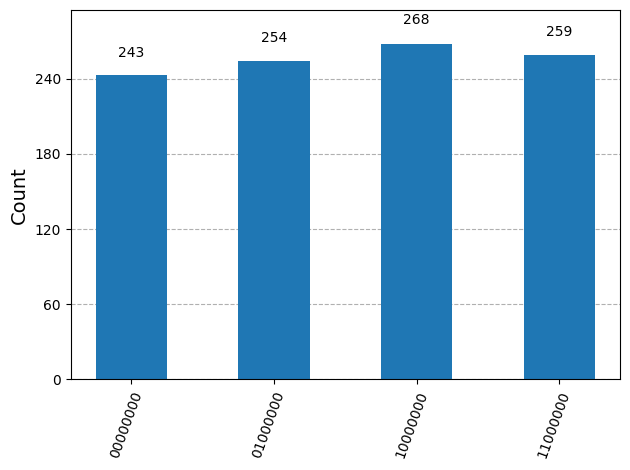

In [ ]:
general_q_obj = aer_sim.run(t_general_qc)
results = general_q_obj.result()
counts = results.get_counts()
print("Measurement outcomes:", counts)
plot_histogram(counts)

In [ ]:
rows, measured_phases = [], []

for output in counts:
  decimal = int(output, 2)
  phase = decimal/(2**control_n_qubits)
  measured_phases.append(phase)


  rows.append([f"{output}(bin) = {decimal:>3}(dec)",
               f"{decimal}/{2**control_n_qubits} = {phase:.2f}"])

headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns = headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [ ]:
rows = []
for phase in measured_phases:
  frac = Fraction(phase).limit_denominator(15) # denominator cant be greater than the number itself
  rows.append([phase, f"{frac.numerator}/{frac.denominator}",frac.denominator])

headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns = headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.75      3/4            4
2   0.25      1/4            4
3   0.00      0/1            1


In [ ]:


# Print a summary
print("🔧 Circuit diagnostics:")
print("- Total qubits:     ", t_general_qc.num_qubits)
print("- Total gates:      ", t_general_qc.size())
print("- Circuit depth:    ", t_general_qc.depth())
print("- Classical bits:   ", t_general_qc.num_clbits)

# Breakdown of gate types
print("\n🧱 Gate breakdown:")
gate_counts = t_general_qc.count_ops()
for gate, count in gate_counts.items():
    print(f"- {gate:8}: {count}")

🔧 Circuit diagnostics:
- Total qubits:      12
- Total gates:       2282
- Circuit depth:     2139
- Classical bits:    8

🧱 Gate breakdown:
- unitary : 1125
- cx      : 1078
- cp      : 28
- u3      : 26
- h       : 14
- measure : 8
- diagonal: 2
- x       : 1


In [ ]:
t_general_qc_forced = transpile(
    general_qc,
    basis_gates=['u3', 'cx'],
    optimization_level=1  # or 2/3 for more aggressive optimization
)

In [ ]:
# Print a summary
print("🔧 Circuit diagnostics:")
print("- Total qubits:     ", t_general_qc_forced.num_qubits)
print("- Total gates:      ", t_general_qc_forced.size())
print("- Circuit depth:    ", t_general_qc_forced.depth())
print("- Classical bits:   ", t_general_qc_forced.num_clbits)

# Breakdown of gate types
print("\n🧱 Gate breakdown:")
gate_counts = t_general_qc_forced.count_ops()
for gate, count in gate_counts.items():
    print(f"- {gate:8}: {count}")

🔧 Circuit diagnostics:
- Total qubits:      12
- Total gates:       2595
- Circuit depth:     2349
- Classical bits:    8

🧱 Gate breakdown:
- u3      : 1357
- cx      : 1230
- measure : 8
